https://stackoverflow.com/questions/24356683/apply-grouped-model-back-onto-data

In [2]:
library(dplyr)
library(broom)
library(tibble)
library(tidyr)
library(purrr)
library(caret)

In [3]:
dim(iris)
head(iris)

[1] 150   5

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
5.1,3.5,1.4,0.2,setosa
4.9,3.0,1.4,0.2,setosa
4.7,3.2,1.3,0.2,setosa
4.6,3.1,1.5,0.2,setosa
5.0,3.6,1.4,0.2,setosa
5.4,3.9,1.7,0.4,setosa


In [4]:
set.seed(13579)
trainIndex <- createDataPartition(iris$Species, p = .8, 
                                  list = FALSE, 
                                  times = 1)

irisTrain <- iris[ trainIndex,] %>% tbl_df
irisTest  <- iris[-trainIndex,] %>% tbl_df

irisTrain %>% group_by(Species) %>% count()
irisTest %>% group_by(Species) %>% count()

Species,n
setosa,40
versicolor,40
virginica,40


Species,n
setosa,10
versicolor,10
virginica,10


In [5]:
irisTrain %>%
group_by(Species) %>%
nest() %>%
mutate(mod = map(data, ~lm(Sepal.Length ~ Sepal.Width, .) ) ) -> models

print(models)

# A tibble: 3 x 3
     Species              data      mod
      <fctr>            <list>   <list>
1     setosa <tibble [40 x 4]> <S3: lm>
2 versicolor <tibble [40 x 4]> <S3: lm>
3  virginica <tibble [40 x 4]> <S3: lm>


# A tibble: 3 x 3
     Species              data      mod
      <fctr>            <list>   <list>
1     setosa <tibble [10 x 4]> <S3: lm>
2 versicolor <tibble [10 x 4]> <S3: lm>
3  virginica <tibble [10 x 4]> <S3: lm>
# A tibble: 3 x 4
     Species              data      mod Sepal.Length.Pred
      <fctr>            <list>   <list>            <list>
1     setosa <tibble [10 x 4]> <S3: lm>        <dbl [10]>
2 versicolor <tibble [10 x 4]> <S3: lm>        <dbl [10]>
3  virginica <tibble [10 x 4]> <S3: lm>        <dbl [10]>


Species,Sepal.Length.Pred,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
setosa,5.045048,5.1,3.5,1.4,0.2
setosa,4.691156,4.9,3.0,1.4,0.2
setosa,4.974269,4.6,3.4,1.4,0.3
setosa,5.682054,5.7,4.4,1.5,0.4
setosa,5.328162,5.4,3.9,1.3,0.4
setosa,4.974269,5.0,3.4,1.6,0.4


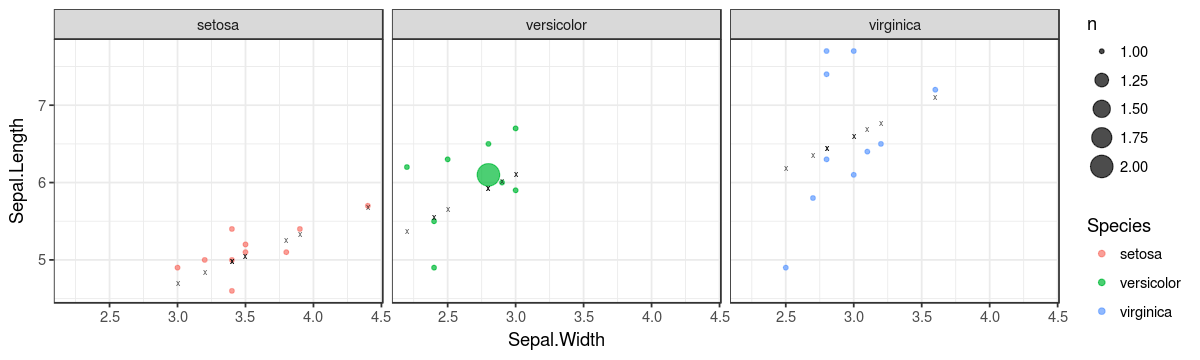

In [7]:
irisTest %>% 
nest(-Species) %>%
inner_join(models %>% select(-data), by="Species") -> x

x %>% print

x %>% mutate(Sepal.Length.Pred = map2(mod, data, predict)) -> y
y %>% print

z = y %>% select(-mod) %>% unnest()
z %>% head

options(repr.plot.width = 10, repr.plot.height = 3)

ggplot() +
geom_count(data=z, aes(x=Sepal.Width, y=Sepal.Length, colour = Species), alpha=0.7) +
geom_point(data=z, aes(x=Sepal.Width, y=Sepal.Length.Pred), alpha=0.7, color="black", shape='x') +
facet_wrap(~Species) +
theme_bw()